<a href="https://colab.research.google.com/github/RadiantRose19/disaster_analysis/blob/main/ta_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

df = pd.read_csv('/content/turkey_syria_earthquake_posts.csv', header=0)
print(df.head())

   ID         Username                                       Post Message  \
0   1  @HindHassanNews  I keep thinking about the thousands trapped un...   
1   2       @AJEnglish  Victims still alive under rubble plead for hel...   
2   3       @AJEnglish  Videos of a woman who filmed herself trapped u...   
3   4    @activistjyot  People & Children trapped in collapsed and dam...   
4   5       @OnuaSmart  Still Rescuers race against time to find survi...   

   Unnamed: 3                              Location  
0         NaN     Antakya, Turkey / Northwest Syria  
1         NaN  Kahramanmaraş, Turkey / Idlib, Syria  
2         NaN         Hatay, Turkey / Aleppo, Syria  
3         NaN   Gaziantep, Turkey / Jandaris, Syria  
4         NaN        Antakya, Turkey / Harem, Syria  


In [ ]:
print(df.shape)

(108, 5)


In [ ]:
print(df.isnull().sum())

ID                0
Username          0
Post Message      0
Unnamed: 3      108
Location          1
dtype: int64


In [ ]:
# Clean column names if needed
df.columns = ['ID', 'Username', 'Post', 'Empty', 'Location']
df = df.drop('Empty', axis=1, errors='ignore')
df['Post'] = df['Post'].fillna('')
df['Location'] = df['Location'].fillna('Unknown')
print(df['Location'].value_counts().head())

Location
Kahramanmaraş, Turkey    13
Hatay, Turkey            11
Gaziantep, Turkey        11
Antakya, Turkey          10
Adıyaman, Turkey          8
Name: count, dtype: int64


In [ ]:
# Snippet 3: Text Preprocessing Function
def clean_text(text):
    if pd.isna(text):
        return ''
    text = re.sub(r'http\S+|www\S+|https\S+', '', str(text), flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags (keep if analyzing separately)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text.lower())  # Lowercase, remove non-alpha
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize spaces
    return textf3e

df['clean_post'] = df['Post'].apply(clean_text)
print("Sample cleaned post:", df['clean_post'].iloc[0])

Sample cleaned post: i keep thinking about the thousands trapped under the rubble their relief when they re rescued or the desperation when they realise help won t get to them this is our report from syria turkey on the miracles endless tragedies caused by the earthquakes


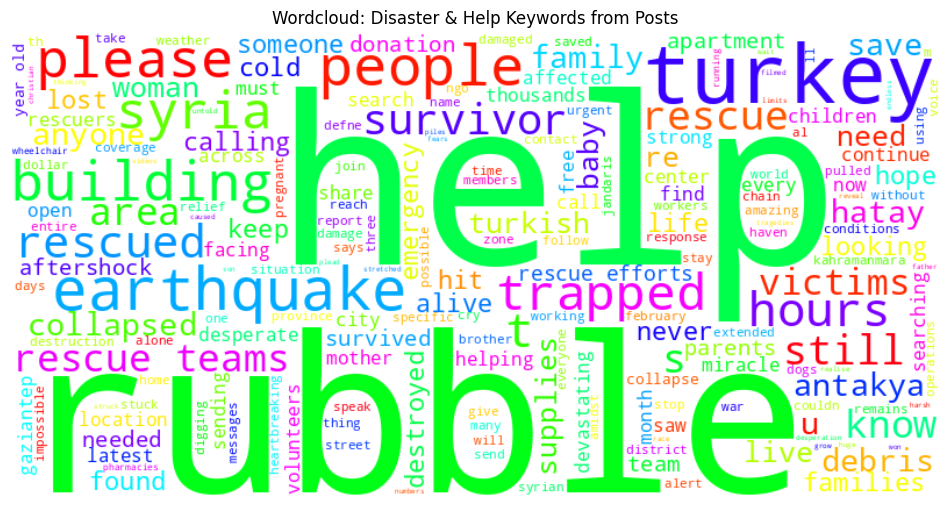

In [ ]:
#Wordcloud for Help/Disaster Keyword
disaster_keywords = ['rubble', 'trapped', 'rescue', 'help', 'earthquake', 'collapsed', 'debris', 'save']

df['disaster_related'] = df['clean_post'].apply(lambda x: any(kw in x for kw in disaster_keywords))
disaster_text = ' '.join(df[df['disaster_related']]['clean_post'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='gist_rainbow').generate(disaster_text)

plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud: Disaster & Help Keywords from Posts')
plt.show()

/tmp/ipython-input-1983315740.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_locs.keys()), y=list(top_locs.values()), palette='pastel')


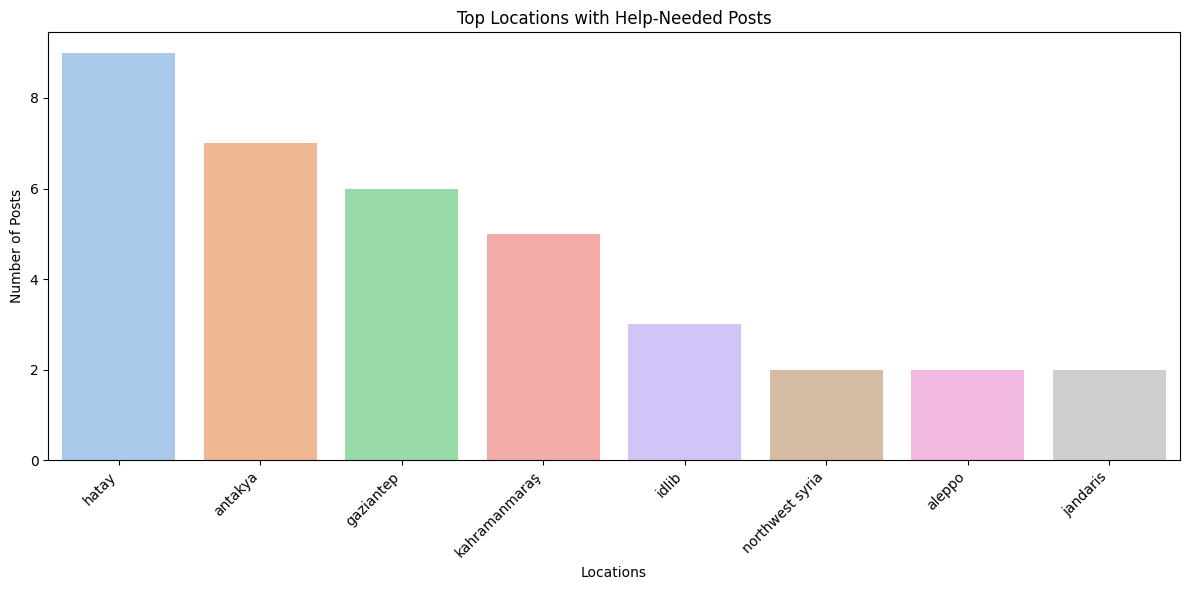

In [ ]:
#Sentiment Classification (Help Needed vs Positive) and Barplot
help_keywords = ['help', 'trapped', 'save', 'please', 'under rubble', 'collapsed']
positive_keywords = ['rescued', 'survived', 'miracle', 'alive', 'hope', 'found']
df['help_needed'] = df['clean_post'].apply(lambda x: any(re.search(r'\b' + kw + r'\b', x) for kw in help_keywords))
df['positive'] = df['clean_post'].apply(lambda x: any(re.search(r'\b' + kw + r'\b', x) for kw in positive_keywords))

#Barplot for Locations with Most Help-Needed Posts
def extract_locations(loc_str):
    if pd.isna(loc_str):
        return []
    parts = re.split(r'[/,]', str(loc_str).lower())
    cities = [p.strip() for p in parts if len(p.strip()) > 2 and p.strip() not in ['turkey', 'syria', 'and', 'multiple', 'global']]
    return cities

help_df = df[df['help_needed']]
locations_help = []
for loc in help_df['Location']:
    locations_help.extend(extract_locations(loc))

loc_counts = Counter(locations_help)
top_locs = dict(loc_counts.most_common(8))  # Top 8 for clarity

plt.figure(figsize=(12, 6))
sns.barplot(x=list(top_locs.keys()), y=list(top_locs.values()), palette='pastel')
plt.title('Top Locations with Help-Needed Posts')
plt.xlabel('Locations')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-993328679.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=counts, palette='viridis')


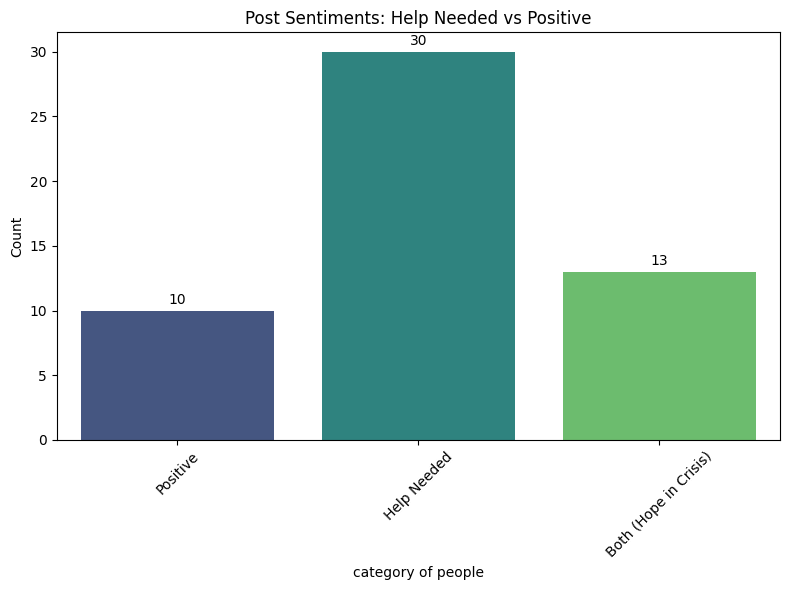

In [ ]:
# Counts (accounting for overlap)
num_help = df['help_needed'].sum()
num_positive = df['positive'].sum()
num_both = ((df['help_needed']) & (df['positive'])).sum()

categories = ['Positive', 'Help Needed', 'Both (Hope in Crisis)']
counts = [num_positive - num_both, num_help - num_both, num_both]

plt.figure(figsize=(8, 6))
sns.barplot(x=categories, y=counts, palette='viridis')
plt.title('Post Sentiments: Help Needed vs Positive')
plt.xlabel('category of people')
plt.ylabel('Count')
plt.xticks(rotation=45)
for i, v in enumerate(counts):
    plt.text(i, v + 0.5, str(v), ha='center')
plt.tight_layout()
plt.show()

In [ ]:
vectorizer = TfidfVectorizer(max_features=20, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(help_df['clean_post'])
feature_names = vectorizer.get_feature_names_out()

In [ ]:
#Urgency Scoring for Prioritization
urgency_keywords = {
    'time_critical': ['hours', 'days', 'trapped', 'under rubble', 'still alive'],  # +3 points
    'vulnerable': ['child', 'baby', 'elderly', 'pregnant', 'injured'],  # +2
    'urgent_call': ['please help', 'send rescue', 'now', 'hurry'],  # +1
    'de-escalate': ['rescued', 'found']  # -1 if positive but still flagged
}

def calculate_urgency(post):
    score = 0
    post_lower = post.lower()
    for cat, kws in urgency_keywords.items():
        for kw in kws:
            if kw in post_lower:
                if cat == 'de-escalate':
                    score -= 1
                else:
                    score += 3 if cat == 'time_critical' else 2 if cat == 'vulnerable' else 1
    return max(0, score)  # Non-negative

df['urgency_score'] = df['clean_post'].apply(calculate_urgency)
high_priority = df[df['urgency_score'] >= 4].sort_values('urgency_score', ascending=False)
print("High Priority Posts for Action:")
print(high_priority[['Post', 'urgency_score']].head(10))

High Priority Posts for Action:
                                                 Post  urgency_score
58  My 6 month old baby survived 50 hours under ru...              8
1   Victims still alive under rubble plead for hel...              6
43  Drove 12 hours from Istanbul with supplies. No...              6
71  8 months pregnant and rescued after 36 hours. ...              6
27  My cousin and her 3 children are under rubble ...              6
3   People & Children trapped in collapsed and dam...              5
4   Still Rescuers race against time to find survi...              5
6   Arrived to S Turkey yesterday & never saw scen...              5
12  Kahramanmaraş #Turkey 🇹🇷 "Please help, Seçkinl...              4
30  Search and rescue operations ongoing in Gazian...              4


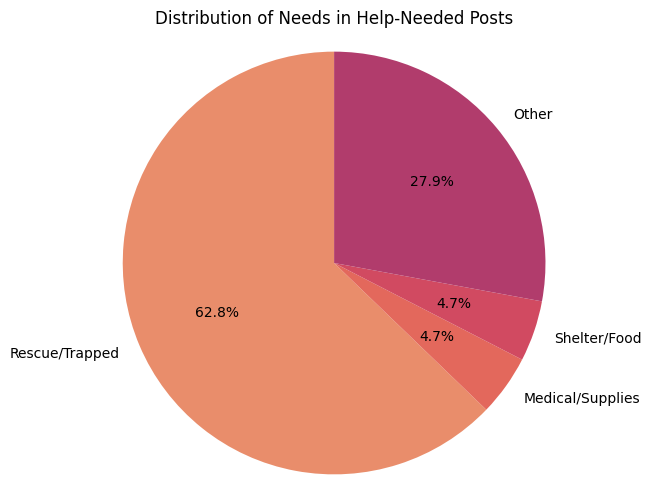

In [ ]:
#Pie Chart for Types of Needs in Help Posts
needs = {'Rescue/Trapped': 0, 'Medical/Supplies': 0, 'Shelter/Food': 0, 'Other': 0}
rescue_kws = ['rescue', 'trapped', 'rubble', 'debris']
med_kws = ['medical', 'hospital', 'blood', 'injured', 'doctor']
shelter_kws = ['tent', 'food', 'water', 'blanket', 'shelter', 'donate']

for post in help_df['clean_post']:
    cat = 'Other'
    if any(kw in post for kw in rescue_kws):
        cat = 'Rescue/Trapped'
    elif any(kw in post for kw in med_kws):
        cat = 'Medical/Supplies'
    elif any(kw in post for kw in shelter_kws):
        cat = 'Shelter/Food'
    needs[cat] += 1

plt.figure(figsize=(6,6))
plt.pie(needs.values(), labels=needs.keys(), autopct='%1.1f%%', startangle=90, colors=sns.color_palette('flare'))
plt.title('Distribution of Needs in Help-Needed Posts')
plt.axis('equal')
plt.show()

In [ ]:
#code segment that filters the details of person(username) with respect to word cloud
disaster_keywords = ['rubble', 'trapped', 'rescue', 'help', 'earthquake', 'collapsed', 'debris', 'save']

df['is_disaster'] = df['clean_post'].apply(
    lambda x: any(kw in x for kw in disaster_keywords)
)

filtered_details = df[df['is_disaster']][['Username', 'Location']].reset_index(drop=True)

print("Posts that contributed to the word cloud (Username + Location):")
filtered_details.head(10)

Posts that contributed to the word cloud (Username + Location):


,Username,Location
0,@HindHassanNews,"Antakya, Turkey / Northwest Syria"
1,@AJEnglish,"Kahramanmaraş, Turkey / Idlib, Syria"
2,@AJEnglish,"Hatay, Turkey / Aleppo, Syria"
3,@activistjyot,"Gaziantep, Turkey / Jandaris, Syria"
4,@OnuaSmart,"Antakya, Turkey / Harem, Syria"
5,@trtworld,"Kahramanmaraş, Turkey"
6,@lalarian,"Hatay, Turkey"
7,@ANI,"Antakya, Turkey"
8,@OfficialMalbec,"Kahramanmaraş, Turkey"
9,@amanpour,"Gaziantep, Turkey / Idlib, Syria"
